# Fraud Detection - Modelling

Create a model that predicts whether a transaction is fraudulent or not.

In [1]:
from multiprocessing import Pool, TimeoutError
import os
import yaml

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import shap
import xgboost as xgb

from fin_crime.data_processor import DataProcessor
from fin_crime.model import custom_eval_metrics, fit_xgb_classifier

/Users/gleb/miniconda3/envs/fincrime/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pd.options.display.max_columns = 100

In [3]:
shap.initjs()

# Defines

In [4]:
num_cores = os.cpu_count()
input_data_dir = os.path.join("data", "processed")

In [5]:
dp = DataProcessor(
    input_data_dir
)

In [6]:
# features
x_cols_categorical = [
    "category",
    "gender",
    "trans_hour",
    "job_short",
    "merchant",
    "merchant_state",
    "card_state"
]
x_cols_cont = [
    "amt",
    "age_at_transaction",
    "city_pop",
    
]
x_cols = x_cols_categorical + x_cols_cont

# target
y_col = "is_fraud"

# Data

In [7]:
# Compressed job titles - courtesy of ChatGPT
with open(os.path.join("data", "compressed_job_titles.yml")) as f:
    job_map = yaml.load(f, Loader=yaml.FullLoader)['compressed_job_titles']

In [8]:
df_train = pd.read_parquet(
    os.path.join(input_data_dir, "tr_fincrime_train.parquet")
)

df_eval = pd.read_parquet(
    os.path.join(input_data_dir, "tr_fincrime_test.parquet")
)

In [9]:
df_train = dp.process(df_train)
df_eval = dp.process(df_eval)

In [10]:
df_train['job_short'] = df_train['job'].replace(job_map)
df_eval['job_short'] = df_eval['job'].replace(job_map)

In [11]:
for cur_df in [df_train, df_eval]:
    cur_df[x_cols_categorical] = cur_df[x_cols_categorical].astype("category")

# Baseline Models

Recall of fraudulent transactions is the key metric used to validate model performance:

- Missing a fraudulent transaction is more expensive for the business than doing a check

## Estimation

- XGBoost classifier with class-scaled loss
- Stratified K-Fold with 5 folds and 3 sets of hyperparameters

In [12]:
n_folds = 5

skf = StratifiedKFold(
    n_splits=n_folds, 
    shuffle=True,
    random_state=42
)

In [13]:
params_base = {
    'objective': 'binary:logistic',
    'scale_pos_weight': (df_train[y_col] == 0).sum() / (df_train[y_col] == 1).sum(),
    "learning_rate": 0.01,
}

params_low_reg = params_base | {
    "min_child_weight": 1,
    "gamma": 0.01,
    "max_depth": 15,
    "subsample": 1,
    "reg_alpha": 0.0,
    "reg_lambda": 0.0
}

params_med_reg = params_base | {
    "min_child_weight": 10,
    "gamma": 0.1,
    "max_depth": 10,
    "subsample": 0.8,
    "reg_alpha": 0.1,
    "reg_lambda": 0.1
}

params_high_reg = params_base | {
    "min_child_weight": 25,
    "gamma": 0.5,
    "max_depth": 8,
    "subsample": 0.5,
    "reg_alpha": 0.5,
    "reg_lambda": 0.5
}

params = {
    "params_low_reg": params_low_reg,
    "params_med_reg": params_med_reg,
    "params_high_reg": params_high_reg,
}

num_boost_round = 1000
early_stopping_rounds = 50
fit_timeout = 600  # Adjust if necessary

In [14]:
# Iterating over hyperparameters
out_dict = {}

for cur_name, cur_params in tqdm(params.items()):
    skf_gen = skf.split(df_train[x_cols], df_train[y_col])

    with Pool(processes=min(num_cores - 1, n_folds)) as pool:
        out = pool.starmap_async(
            fit_xgb_classifier, 
            [
                (cur_params, df_train, x_cols, y_col, train_idx, test_idx, num_boost_round, early_stopping_rounds) 
                for _, (train_idx, test_idx) in enumerate(skf_gen)
            ]
        )
    
        try:
            result = out.get(timeout=fit_timeout)
        except TimeoutError:
            print("Timeout")
            result = None

    out_dict[cur_name] = result

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:39<00:00, 73.22s/it]


## Performance

- There is a trade-off between precision and recall which we have to make - `params_med_reg` set of hyperparameters (middle of the road amount of regularisation) could be an OK choice to keep the amount of false positives under control
- Higher regularisation gives an overall best fraud recall

In [15]:
# Preparing Metrics
metric_list = []

for cur_name, cur_out in out_dict.items():
    for cur_fold, _ in enumerate(cur_out):
        
        df_metrics_train = pd.DataFrame(
            cur_out[cur_fold][0]["train"]
        )
        
        df_metrics_eval = pd.DataFrame(
            cur_out[cur_fold][0]["eval"]
        )
        
        df_metrics_train["step"] = df_metrics_train.index.values
        df_metrics_eval["step"] = df_metrics_eval.index.values
        
        df_metrics_train["type"] = "train"
        df_metrics_eval["type"] = "eval"
        
        df_metrics = pd.concat([df_metrics_train, df_metrics_eval], ignore_index=True)
        df_metrics["fold"] = cur_fold
        df_metrics["param"] = cur_name

        metric_list.append(df_metrics)

In [16]:
df_metrics_all = pd.concat(metric_list)

df_metrics_agg = df_metrics_all.groupby(
    ["param", "type", "step"],
)[["f1", "precision_class_1", "recall_class_1"]].mean()

df_metrics_agg = df_metrics_agg.join(
    df_metrics_all.groupby(
        ["param", "type", "step"],
    )["recall_class_1"].size().to_frame("count")
)

df_metrics_agg = df_metrics_agg.loc[
    df_metrics_agg["count"] == n_folds
]

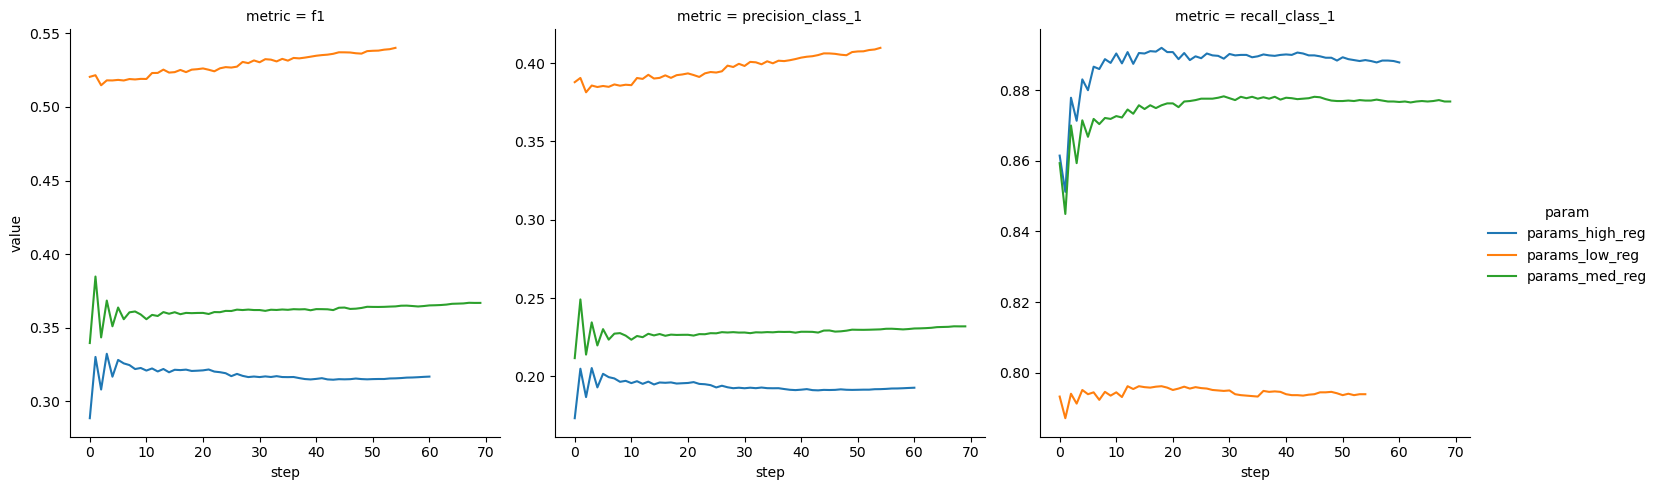

In [17]:
df_plot = df_metrics_agg.reset_index().melt(
    id_vars=['param', 'type', 'step'],
    var_name='metric',
    value_vars=['f1', 'precision_class_1', 'recall_class_1']
)

sns.relplot(
    data=df_plot[df_plot['type'] != 'train'],
    x='step',
    y='value',
    hue='param',
    col='metric',
    kind='line',
    facet_kws={"sharey": False}
)

Text(0.5, 1.02, 'Fraud Recall Bias')

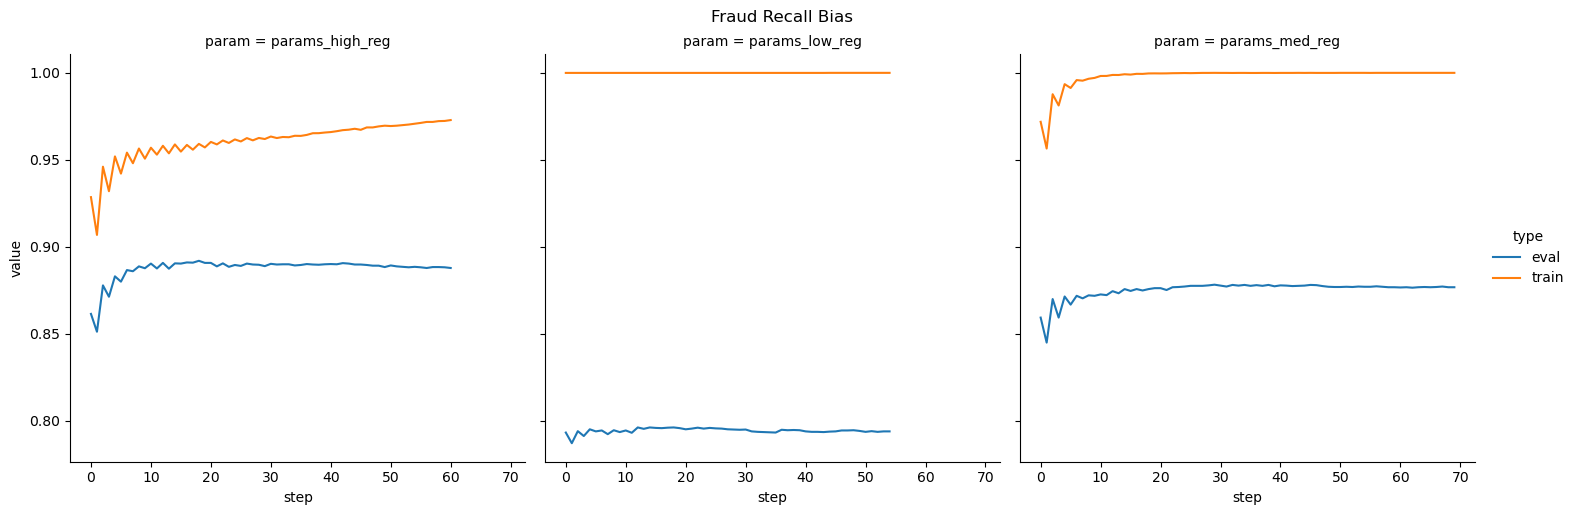

In [18]:
df_plot = df_metrics_agg.reset_index().melt(
    id_vars=['param', 'type', 'step'],
    var_name='metric',
    value_vars=['f1', 'precision_class_1', 'recall_class_1']
)

sns.relplot(
    data=df_plot[df_plot['metric'] == 'recall_class_1'],
    x='step',
    y='value',
    hue='type',
    col='param',
    kind='line',
    facet_kws={"sharey": True}
)

plt.suptitle('Fraud Recall Bias', y=1.02)

## Final Performance

Using `params_high_reg` and full data. We dropped nearly 9 pp. of recall - this suggests there is still overfitting to the train dataset somewhere, despite regularisation we are doing:

In [19]:
dtrain = xgb.DMatrix(df_train[x_cols], label=df_train[y_col], enable_categorical=True)
deval = xgb.DMatrix(df_eval[x_cols], label=df_eval[y_col], enable_categorical=True)

evals = [(dtrain, 'train'), (deval, 'eval')]

In [20]:
cur_evals_result = {}

model = xgb.train(
    params_high_reg,
    dtrain,
    num_boost_round=num_boost_round,
    evals=evals,
    evals_result=cur_evals_result,
    early_stopping_rounds=early_stopping_rounds,
    custom_metric=custom_eval_metrics,
    maximize=True,
    verbose_eval=None
)

In [21]:
# Best recall achieved
pd.DataFrame(cur_evals_result['eval'])['recall_class_1'].max()

0.814452

<Axes: >

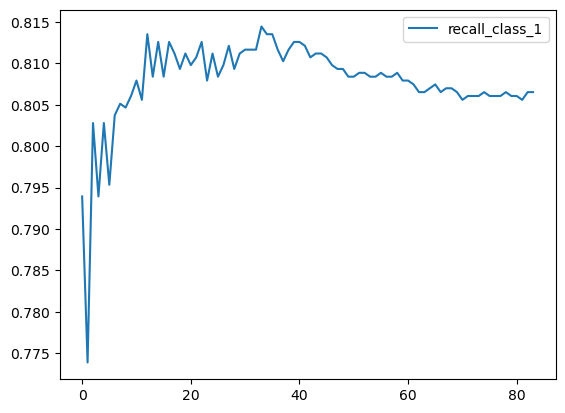

In [22]:
pd.DataFrame(cur_evals_result['eval']).plot(y='recall_class_1')

## SHAP Plots

- The model associates transaction amounts and hour of the transaction with changes in fraud odds
- *food_dining* and *travel* values of `category` (shopping category) feature are associated with lower fraud odds
- Some job titles were associated with lower fraud odds
- Some merchants were associated with higher fraud odds on average, however the names of merchants were not the same as those picked up in EDA
- Gender had no impact on predictions

In [23]:
explainer = shap.TreeExplainer(model)

In [24]:
shap_values_train = explainer.shap_values(dtrain)
df_shap_values_train = pd.DataFrame(
    shap_values_train,
    columns=x_cols
)

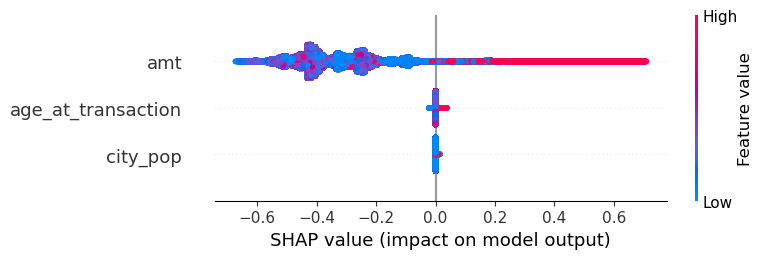

In [25]:
# Plot of SHAP values for continuous features
shap.summary_plot(
    shap_values_train[:, [i for i, v in enumerate(x_cols) if v in x_cols_cont]],
    df_train[x_cols_cont]
)

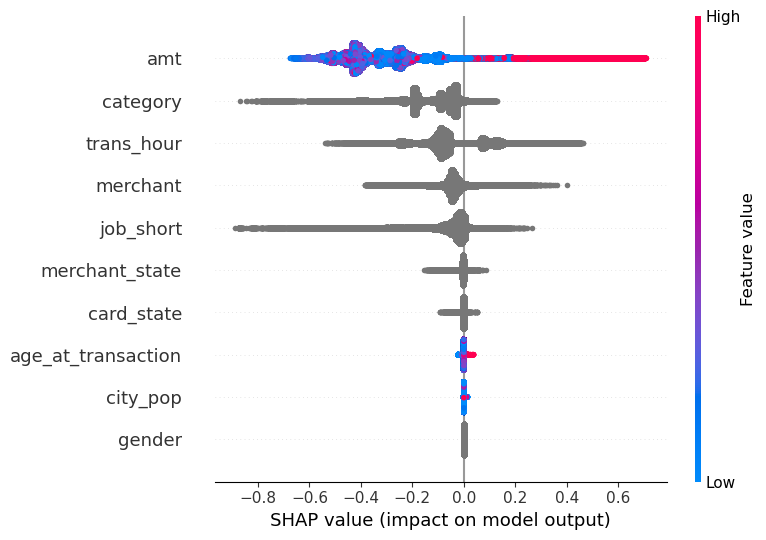

In [26]:
# Plot of SHAP values for all features
shap.summary_plot(
    shap_values_train,
    df_train[x_cols]
)

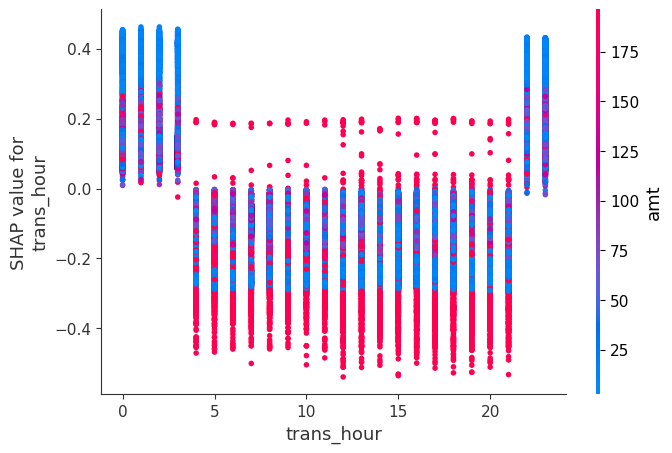

In [27]:
# Plot of SHAP values for transaction hour
shap.dependence_plot(
    'trans_hour',
    shap_values_train,
    df_train[x_cols]
)

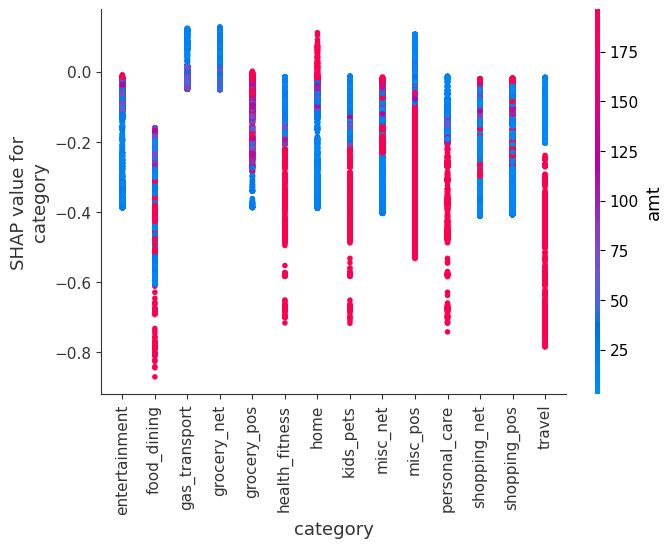

In [28]:
# Plot of SHAP values for transaction category
shap.dependence_plot(
    'category',
    shap_values_train,
    df_train[x_cols]
)

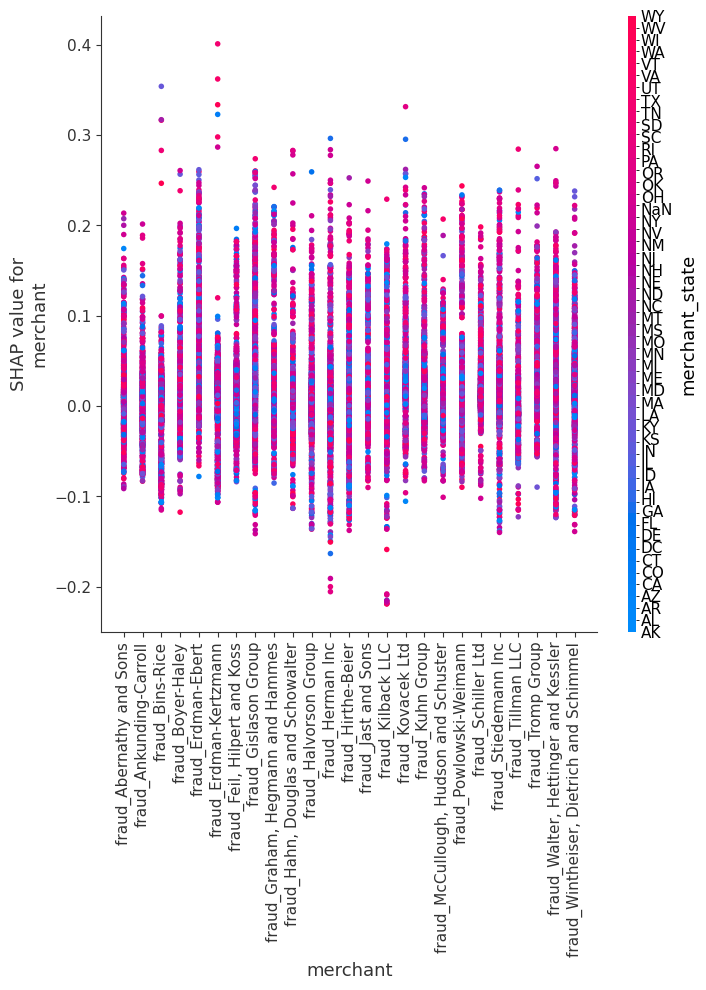

In [29]:
# Plot of SHAP values for categorical features
df_tmp = df_shap_values_train[['merchant']].copy()
df_tmp['merchant_name'] = df_train['merchant']
merchant_sample = df_tmp.groupby('merchant_name', observed=True).mean().sort_values(by='merchant').tail(25).index.tolist()

_, axes = plt.subplots(figsize=(8, 8))

shap.dependence_plot(
    "merchant",
    shap_values_train[df_train[df_train["merchant"].isin(merchant_sample)].index.tolist(), :],
    df_train.loc[df_train["merchant"].isin(merchant_sample), x_cols],
    interaction_index="merchant_state",
    # interaction_index="amt",
    ax=axes
)

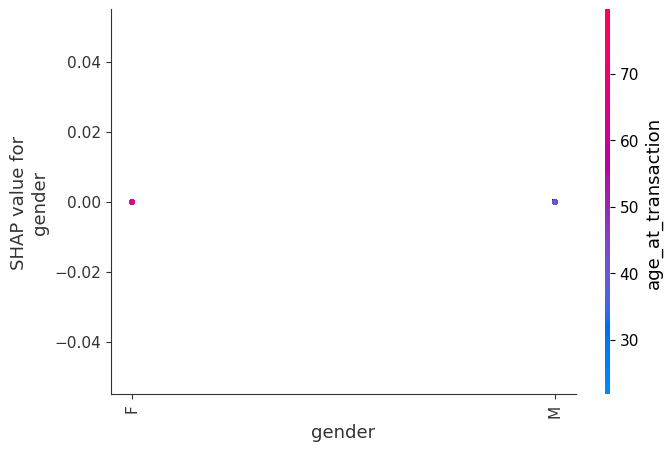

In [30]:
# Gender
shap.dependence_plot(
    'gender',
    shap_values_train,
    df_train[x_cols],
    interaction_index='age_at_transaction'
)

## SHAP Plots on Test Data

I am abusing evaluation data - however the same analysis can be done as part of CV; this is a post-mortem

- Amongst false negatives, `job_short` feature had a persistent negative impact on predictions, followed by `category`
- We might get better results by applying even more regularisation, or removing these features entirely

In [31]:
df_eval['pred_prob'] = model.predict(deval)

shap_values_eval = explainer.shap_values(deval)
df_shap_values_eval = pd.DataFrame(
    shap_values_eval,
    columns=x_cols
)

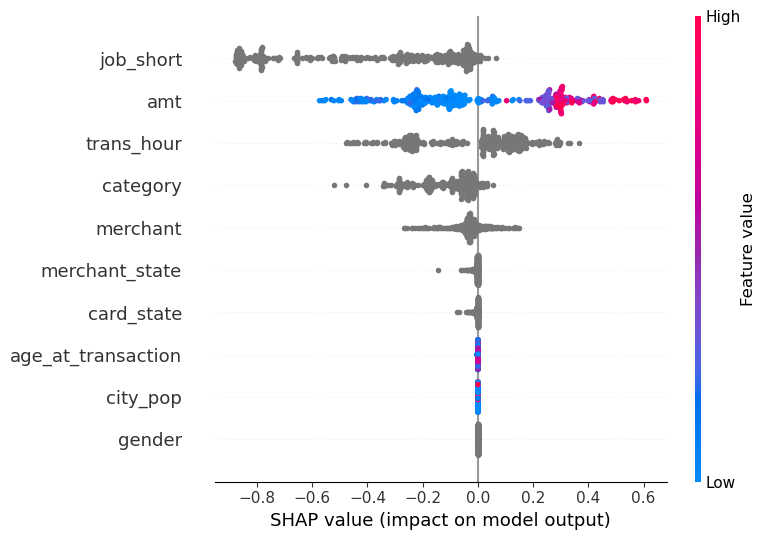

In [32]:
# Plot of SHAP values for continuous features
fn_index = df_eval[(df_eval["is_fraud"] > 0) & (df_eval["pred_prob"] < 0.5)].index
tp_index = df_eval[(df_eval["is_fraud"] > 0) & (df_eval["pred_prob"] >= 0.5)].index

shap.summary_plot(
    shap_values_eval[fn_index.tolist(), :],
    df_eval.loc[fn_index, x_cols]
)

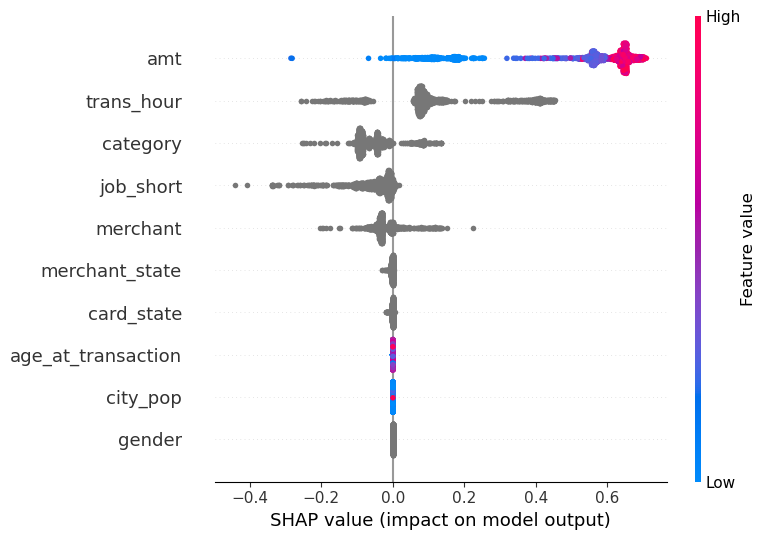

In [33]:
shap.summary_plot(
    shap_values_eval[tp_index.tolist(), :],
    df_eval.loc[tp_index, x_cols]
)

# Adding Time Series Features

I need to exercise caution over how I can treat information about the past fraudulent transactions, especially in the `tr_fincrime_test.csv` dataset:

- Knowing how many fraudulent transactions occured in the past should improve the fit
- However, it is unlikely that this information is immediately available in reality - some time delay between a fraudulent transaction occuring and it being confirmed as such will inevitably occur

We'll check how the fit changes under two scenarios: restrictive and less restrictive

## Shared Hyperparameters

Adding more regularisation as per previous findings

In [34]:
n_folds = 5

skf = StratifiedKFold(
    n_splits=n_folds, 
    shuffle=True,
    random_state=42
)

In [35]:
params_base = {
    'objective': 'binary:logistic',
    'scale_pos_weight': (df_train[y_col] == 0).sum() / (df_train[y_col] == 1).sum(),
    "learning_rate": 0.01,
}

params_low_reg = params_base | {
    "min_child_weight": 1,
    "gamma": 0.01,
    "max_depth": 15,
    "subsample": 1,
    "reg_alpha": 0.0,
    "reg_lambda": 0.0
}

params_med_reg = params_base | {
    "min_child_weight": 10,
    "gamma": 0.1,
    "max_depth": 10,
    "subsample": 0.8,
    "reg_alpha": 0.1,
    "reg_lambda": 0.1
}

params_high_reg = params_base | {
    "min_child_weight": 25,
    "gamma": 0.5,
    "max_depth": 5,
    "colsample_bytree": 0.5,
    "subsample": 0.5,
    "reg_alpha": 1.0,
    "reg_lambda": 1.0
}

params = {
    "params_low_reg": params_low_reg,
    "params_med_reg": params_med_reg,
    "params_high_reg": params_high_reg,
}

num_boost_round = 1000
early_stopping_rounds = 50
fit_timeout = 600  # Adjust if necessary

## No Lookback is allowed

- I am assuming to have no knowledge of any fraudulent transactions in `tr_fincrime_test.csv` at all, even those that happened before the current row
- **==>** I am only adding a boolean which says whether there were any fraudulent transactions from this card in the past 

In [36]:
# How many past fraud cases were there on this card before the current transaction
df_train["is_fraud_cumsum"] = df_train.groupby("cc_num")["is_fraud"].transform("cumsum") - df_train["is_fraud"]
df_train["past_fraud"] = (df_train["is_fraud_cumsum"] > 0)

df_eval["past_fraud"] = False
df_eval.loc[
    df_eval["cc_num"].isin(
        df_train.loc[df_train["past_fraud"], "cc_num"].unique()
    ),
    "past_fraud"
] = True

In [37]:
for cur_df in [df_train, df_eval]:
    cur_df["past_fraud"] = cur_df["past_fraud"].astype("category")

In [38]:
# features
x_cols_categorical = [
    "category",
    "gender",
    "trans_hour",
    "job_short",
    "merchant",
    "merchant_state",
    "card_state",
    "past_fraud"
]
x_cols_cont = [
    "amt",
    "age_at_transaction",
    "city_pop",
    
]
x_cols = x_cols_categorical + x_cols_cont

# target
y_col = "is_fraud"

### Estimation

In [39]:
# Iterating over hyperparameters
out_dict = {}

for cur_name, cur_params in tqdm(params.items()):
    skf_gen = skf.split(df_train[x_cols], df_train[y_col])

    with Pool(processes=min(num_cores - 1, n_folds)) as pool:
        out = pool.starmap_async(
            fit_xgb_classifier, 
            [
                (cur_params, df_train, x_cols, y_col, train_idx, test_idx, num_boost_round, early_stopping_rounds) 
                for _, (train_idx, test_idx) in enumerate(skf_gen)
            ]
        )
    
        try:
            result = out.get(timeout=fit_timeout)
        except TimeoutError:
            print("Timeout")
            result = None

    out_dict[cur_name] = result

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [04:15<00:00, 85.18s/it]


### Performance

In [40]:
# Preparing Metrics
metric_list = []

for cur_name, cur_out in out_dict.items():
    for cur_fold, _ in enumerate(cur_out):
        
        df_metrics_train = pd.DataFrame(
            cur_out[cur_fold][0]["train"]
        )
        
        df_metrics_eval = pd.DataFrame(
            cur_out[cur_fold][0]["eval"]
        )
        
        df_metrics_train["step"] = df_metrics_train.index.values
        df_metrics_eval["step"] = df_metrics_eval.index.values
        
        df_metrics_train["type"] = "train"
        df_metrics_eval["type"] = "eval"
        
        df_metrics = pd.concat([df_metrics_train, df_metrics_eval], ignore_index=True)
        df_metrics["fold"] = cur_fold
        df_metrics["param"] = cur_name

        metric_list.append(df_metrics)

In [41]:
df_metrics_all = pd.concat(metric_list)

df_metrics_agg = df_metrics_all.groupby(
    ["param", "type", "step"],
)[["f1", "precision_class_1", "recall_class_1"]].mean()

df_metrics_agg = df_metrics_agg.join(
    df_metrics_all.groupby(
        ["param", "type", "step"],
    )["recall_class_1"].size().to_frame("count")
)

df_metrics_agg = df_metrics_agg.loc[
    df_metrics_agg["count"] == n_folds
]

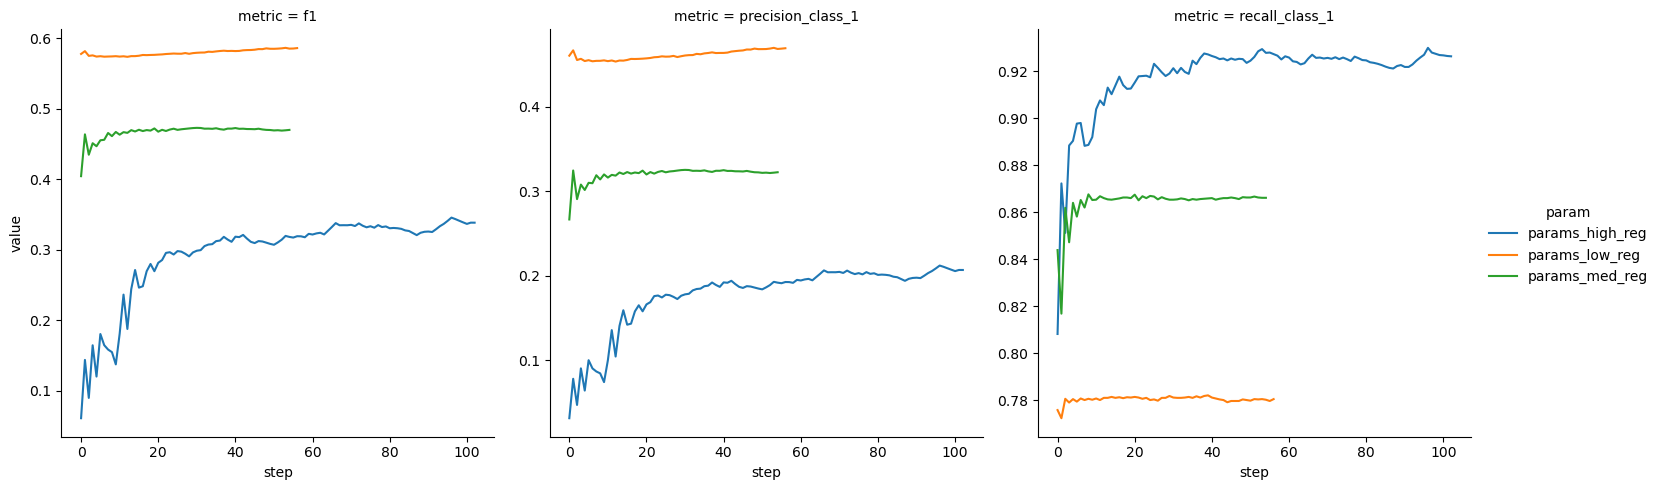

In [42]:
df_plot = df_metrics_agg.reset_index().melt(
    id_vars=['param', 'type', 'step'],
    var_name='metric',
    value_vars=['f1', 'precision_class_1', 'recall_class_1']
)

sns.relplot(
    data=df_plot[df_plot['type'] != 'train'],
    x='step',
    y='value',
    hue='param',
    col='metric',
    kind='line',
    facet_kws={"sharey": False}
)

Text(0.5, 1.02, 'Fraud Recall Bias')

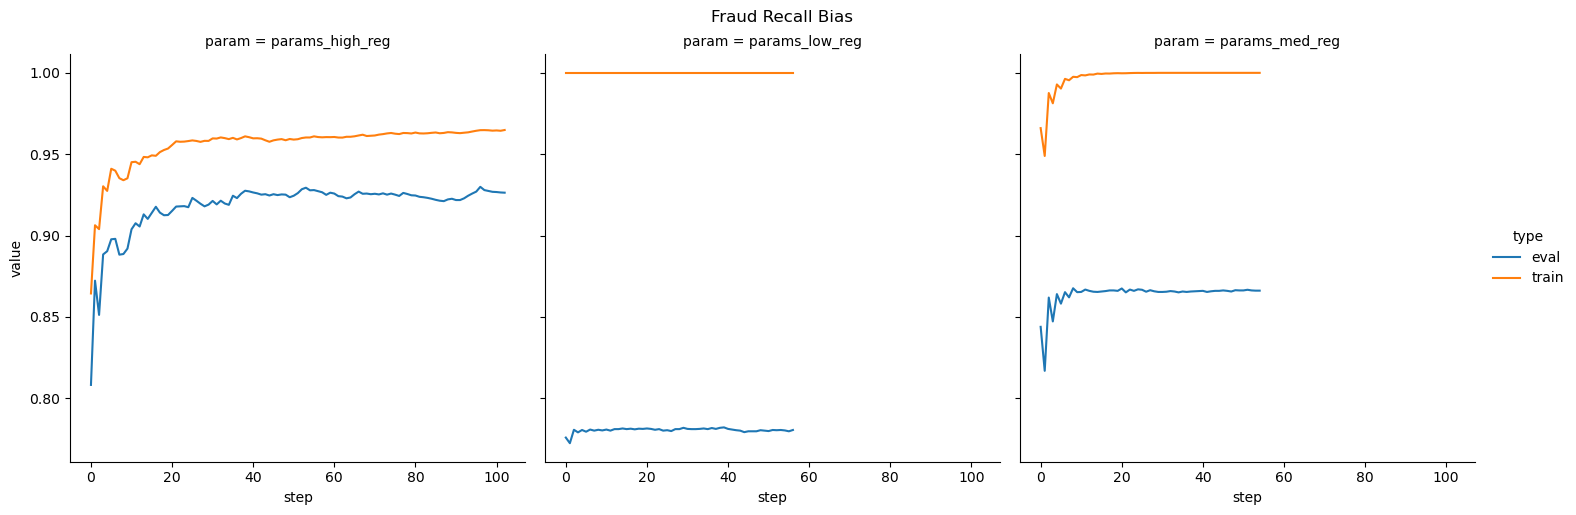

In [43]:
df_plot = df_metrics_agg.reset_index().melt(
    id_vars=['param', 'type', 'step'],
    var_name='metric',
    value_vars=['f1', 'precision_class_1', 'recall_class_1']
)

sns.relplot(
    data=df_plot[df_plot['metric'] == 'recall_class_1'],
    x='step',
    y='value',
    hue='type',
    col='param',
    kind='line',
    facet_kws={"sharey": True}
)

plt.suptitle('Fraud Recall Bias', y=1.02)

### Final Performance

This made the performance worse.

In [44]:
dtrain = xgb.DMatrix(df_train[x_cols], label=df_train[y_col], enable_categorical=True)
deval = xgb.DMatrix(df_eval[x_cols], label=df_eval[y_col], enable_categorical=True)

evals = [(dtrain, 'train'), (deval, 'eval')]

In [45]:
cur_evals_result = {}

model = xgb.train(
    params_high_reg,
    dtrain,
    num_boost_round=num_boost_round,
    evals=evals,
    evals_result=cur_evals_result,
    early_stopping_rounds=early_stopping_rounds,
    custom_metric=custom_eval_metrics,
    maximize=True,
    verbose_eval=None
)

In [46]:
# Best recall achieved
pd.DataFrame(cur_evals_result['eval'])['recall_class_1'].max()

0.744056

<Axes: >

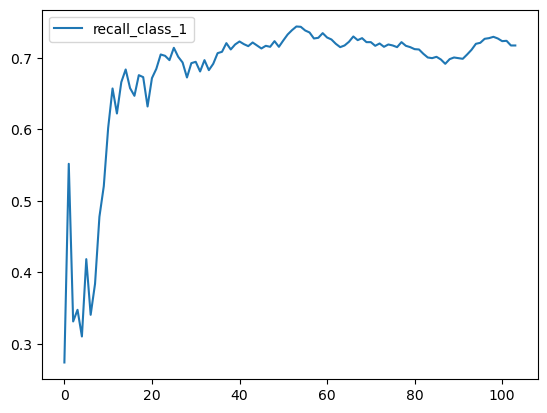

In [47]:
pd.DataFrame(cur_evals_result['eval']).plot(y='recall_class_1')

## Full Lookback

- Fraud status of all past transactions is fully visible, incl. in `tr_fincrime_test.csv`

In [48]:
for df in [df_train, df_eval]:
    df["is_fraud_cumsum"] = df.groupby("cc_num")["is_fraud"].transform("cumsum") - df["is_fraud"]

In [49]:
train_cc_nums = df_train["cc_num"].unique()
df_eval_slice = df_eval.loc[
    df_eval["cc_num"].isin(train_cc_nums)
]

df_eval.loc[
    df_eval_slice.index,
    'is_fraud_cumsum'
] = df_eval_slice['is_fraud_cumsum'] + df_train.groupby('cc_num')['is_fraud_cumsum'].max().loc[df_eval_slice['cc_num']].values

In [50]:
# features
x_cols_categorical = [
    "category",
    "gender",
    "trans_hour",
    "job_short",
    "merchant",
    "merchant_state",
    "card_state",
]
x_cols_cont = [
    "amt",
    "age_at_transaction",
    "city_pop",
    "is_fraud_cumsum"
]
x_cols = x_cols_categorical + x_cols_cont

# target
y_col = "is_fraud"

### Final Performance

Better than before (if attainable).

In [51]:
dtrain = xgb.DMatrix(df_train[x_cols], label=df_train[y_col], enable_categorical=True)
deval = xgb.DMatrix(df_eval[x_cols], label=df_eval[y_col], enable_categorical=True)

evals = [(dtrain, 'train'), (deval, 'eval')]

In [52]:
cur_evals_result = {}

model = xgb.train(
    params_high_reg,
    dtrain,
    num_boost_round=num_boost_round,
    evals=evals,
    evals_result=cur_evals_result,
    early_stopping_rounds=early_stopping_rounds,
    custom_metric=custom_eval_metrics,
    maximize=True,
    verbose_eval=None
)

In [53]:
# Best recall achieved
pd.DataFrame(cur_evals_result['eval'])['recall_class_1'].max()

0.923543

<Axes: >

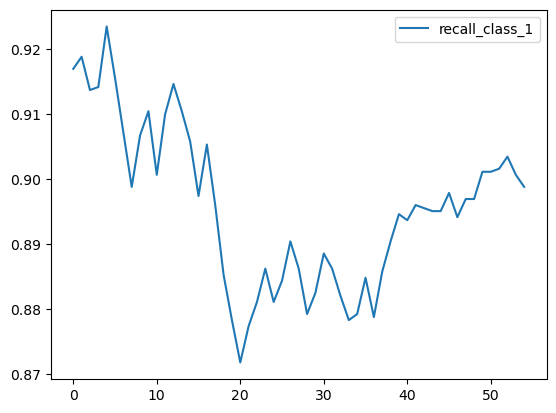

In [54]:
pd.DataFrame(cur_evals_result['eval']).plot(y='recall_class_1')

### SHAP Plots

In [55]:
explainer = shap.TreeExplainer(model)

In [56]:
shap_values_train = explainer.shap_values(dtrain)
df_shap_values_train = pd.DataFrame(
    shap_values_train,
    columns=x_cols
)

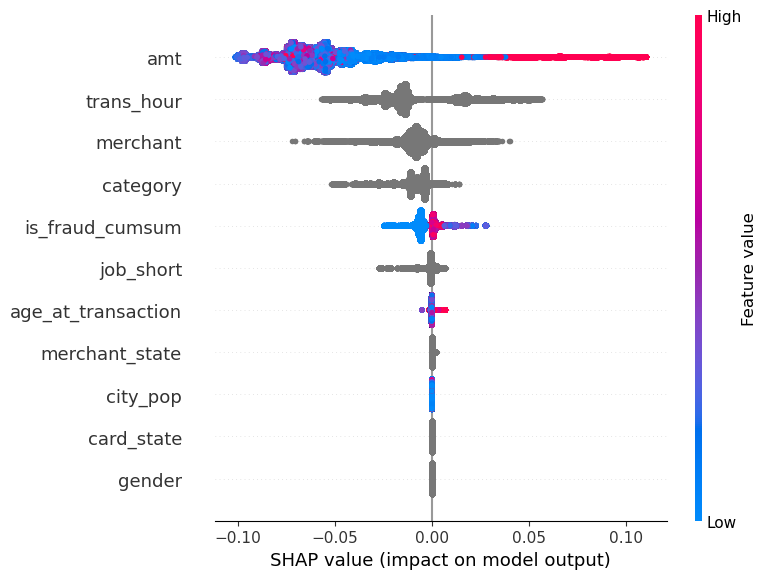

In [57]:
# Plot of SHAP values for all features
shap.summary_plot(
    shap_values_train,
    df_train[x_cols]
)

# Further Improvements

**Methods**

- More comprehensive grid-search
- Use over-sampling / over-sampling
- Other models (e.g. Random Forest, GNN-based for better capture of spacial data, Transformer for TS)

**Data**

- Collect more
- Merchants' histories: how long have they been active, what's their track record, KYB profiles.
- Data from law enforcement agencies: police, court orders, fraud office, etc.
- Cyber-security databases: there are sources which inform users if their details were stolen
- Potential links to organised crime or money laundering: a longer shot given, e.g., Dow Jones PEP/SIP/Sanctions database is unlikely to feature smaller merchants, but worth a shot
- Trusted online reviews for merchants